### Evaluating Jazz album prices on Discogs.com
### Data Analysis
- program: 03_analysis.ipynb
- purpose: readin clean .csv output from 02_dataprep 
- date: jan 17, 2021
- created by: chris chan
- Methods:
    - EDA
    - OLS
    - CV for Model Selection
    - Train, Val, Test data

### 1. Pre Processing

In [254]:
import pandas as pd
import numpy as np
import seaborn as sns 

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


Populating the interactive namespace from numpy and matplotlib


**Read-in clean dataframe**

In [255]:
df=pd.read_csv(r'../data/clean/df_clean.csv')
df.head(3)

,Artist_Album,Label,Country,Format,Genre,Release_Date,Style,Media_Condition,Sleeve_Condition,Seller_Rating,...,reclabel,recyear,sleeve_cond_abbr,media_cond_abbr,seller_rating,rating,votes,haves,wants,price
0,Miles Davis – Volume 2,Blue Note – BLP 1502,US,"Vinyl, LP, Compilation, Remastered, Mono",Jazz,Feb-56,"Hard Bop, Bop",Very Good Plus (VG+),Sleeve: Very Good (VG),98.80%,...,Blue Note,56,VG,VG+,0.988,4.32,25.0,219,302,1100.0
1,Curtis Fuller – The Opener,Blue Note – BLP 1567,US,"Vinyl, LP, Album, Mono",Jazz,1957,Hard Bop,Very Good (VG),Sleeve: Very Good (VG),100.00%,...,Blue Note,57,VG,VG,1.000,4.50,16.0,68,385,2100.0
2,The Jazz Messengers* – At The Cafe Bohemia Vol...,Blue Note – BLP 1508,US,"Vinyl, LP, Album, Mono",Jazz,May-56,Hard Bop,Near Mint (NM or M-),Sleeve: Very Good Plus (VG+),98.80%,...,Blue Note,56,VG+,NM or M-,0.988,4.62,29.0,205,409,770.0


In [234]:
df.shape

(4079, 25)

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4079 entries, 0 to 4078
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist_Album      4079 non-null   object 
 1   Label             4079 non-null   object 
 2   Country           4078 non-null   object 
 3   Format            4079 non-null   object 
 4   Genre             4079 non-null   object 
 5   Release_Date      4079 non-null   object 
 6   Style             4079 non-null   object 
 7   Media_Condition   4079 non-null   object 
 8   Sleeve_Condition  4072 non-null   object 
 9   Seller_Rating     4066 non-null   object 
 10  Recorded_at       2070 non-null   object 
 11  Pressed_by        1249 non-null   object 
 12  Price             4079 non-null   object 
 13  artist            4079 non-null   object 
 14  album             4079 non-null   object 
 15  reclabel          4079 non-null   object 
 16  recyear           4079 non-null   int64  


**1b. Data Cleaning**
- We see Pressed and Recorded at are missing many values. Drop these columns as they are not useful
- Other columns to drop are redundant

In [257]:
df.drop(['Recorded_at','Pressed_by','Seller_Rating','Media_Condition','Sleeve_Condition'], axis=1, inplace=True)

In [258]:
df.describe()

,recyear,seller_rating,rating,votes,haves,wants,price
count,4079.000000,4066.000000,3884.000000,3884.000000,4079.000000,4079.000000,4079.000000
mean,62.136308,0.992452,4.440935,22.474768,189.257416,204.910762,134.473366
std,3.856302,0.025975,0.380680,29.645899,249.913455,280.008017,198.354186
min,52.000000,0.571000,1.000000,1.000000,0.000000,0.000000,40.000000
25%,59.000000,0.995000,4.260000,5.000000,40.000000,59.000000,50.000000
50%,62.000000,0.999000,4.500000,12.000000,95.000000,122.000000,75.000000
75%,65.000000,1.000000,4.670000,27.000000,238.000000,256.000000,140.000000
max,70.000000,1.000000,5.000000,209.000000,1942.000000,3679.000000,5000.000000


**Cleaning Haves / Wants**
- there were very few zeros as haves and wants (<6 each)
- deciding to impute to 1 so we can perform non-zero functions

In [259]:
haveszero = np.array(df['haves'].values.tolist())
df['haves'] = np.where(haveszero ==0 , 1, haveszero).tolist()

wantszero = np.array(df['wants'].values.tolist())
df['wants'] = np.where(wantszero ==0 , 1, wantszero).tolist()

**seller rating**
- Impute with mode

In [260]:
df['seller_rating'].fillna(value=df['seller_rating'].mode(),inplace=True)

**DROPPING rows with NA**
- the remaining NAs are:
    - ratings
    - votes
    - sleeve condition
- these may be not worth imputing at this moment

In [221]:
# In case we want to impute
# df['rating'].fillna(value=df['rating'].mode(),inplace=True)
# df['votes'].fillna(value=df['votes'].mode(),inplace=True)

In [261]:
#df.isnull().values.any()
df.isnull().sum().sum()

560

In [262]:
# Dropping NAN
df.dropna(inplace=True)

In [263]:
df.shape

(3739, 20)

**Pair Plot on numeric FULL DF**

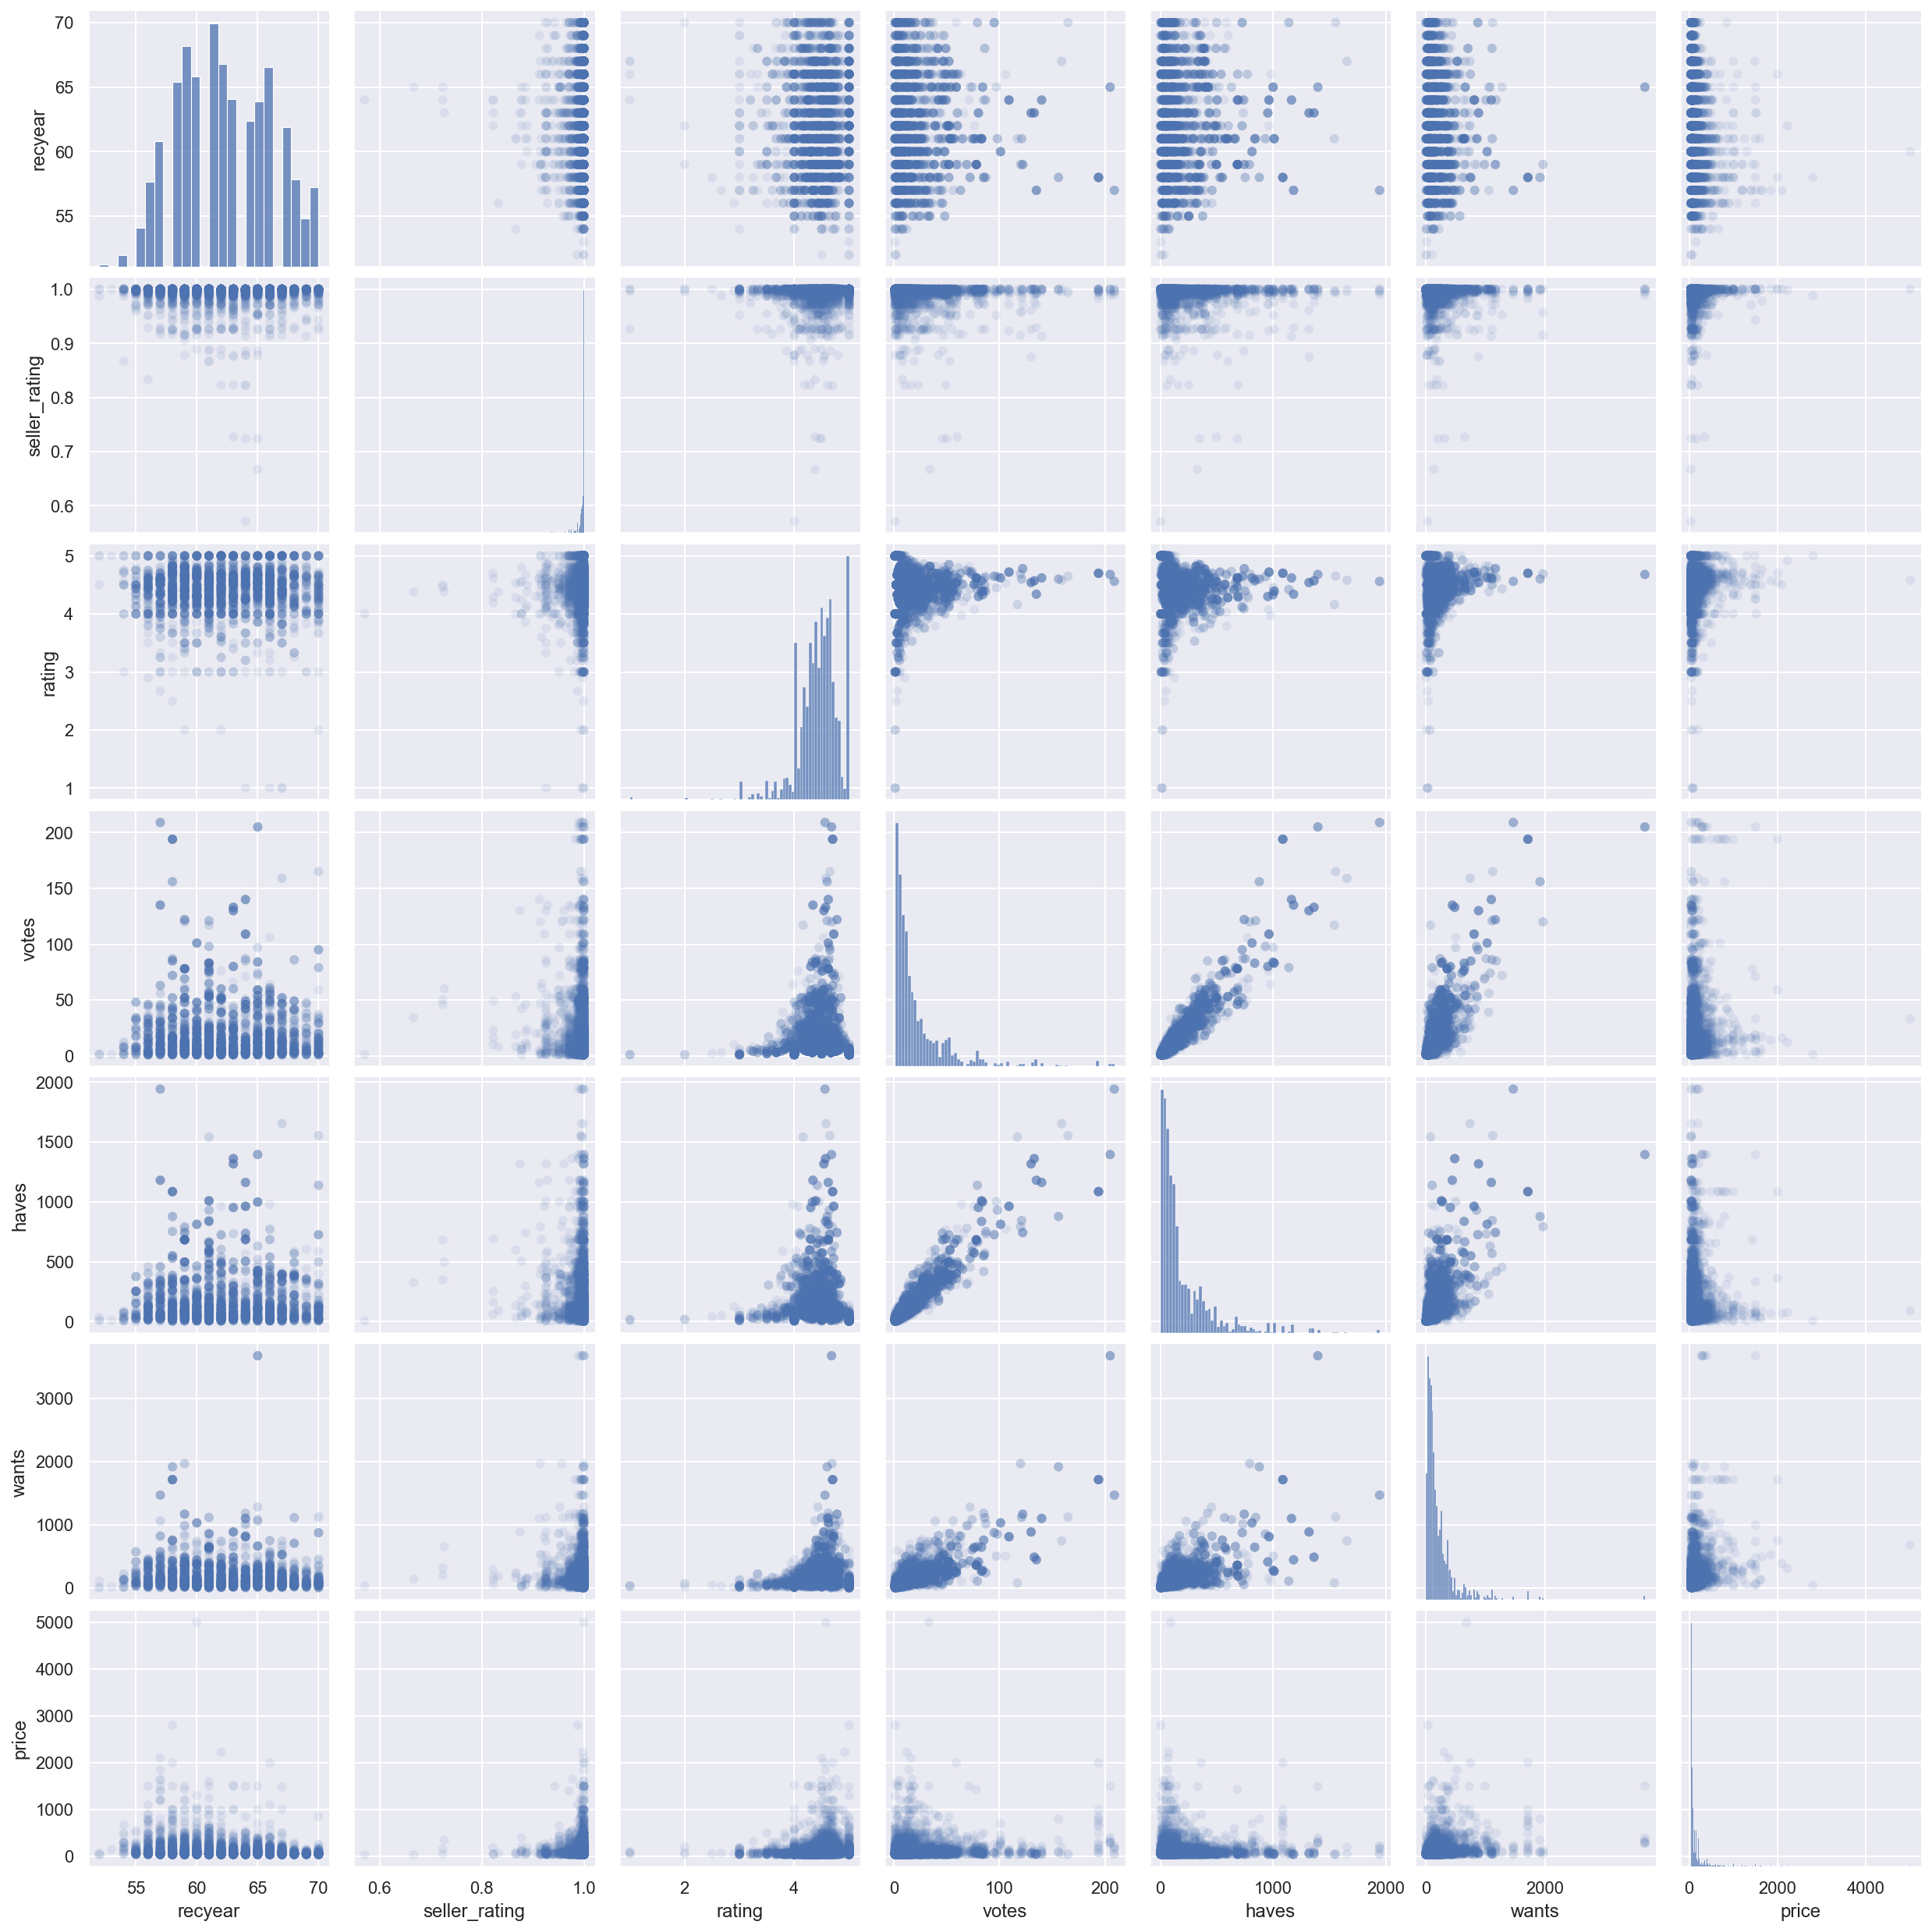

In [276]:
sns.pairplot(df,plot_kws=dict(alpha=.1,edgecolor='none'))

**Observations**
- votes, haves and wants may be colinear with price
- there are some peaks in years that have higher values
- most seller ratings are high, the highest demand the highest price
- some positive correlation with rating and price

### 2. Hold out 20% for Test DF

In [277]:
X , y = df.drop('price',axis=1), df['price']

# hold out 20% of the data for final testing
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# turn into array

**df definitions:**
- **X_ :** Training set (80%) on ALL X columns (cats,cont)
- **X_test :** Test set (20%) on ALL x columns
- **y_ :** Training set (80%) on y (price)
- **y_test:** Test set (20%) on y (price)
- **X :** Full DF, All x columns (cats, cont)
- **y :** Full DF, All y (price)

### 3. Start with numerics (training+validation set only)
- X,Y are full DF and unnecessary
- anything with 'test' is unnecessary at this step
- that leaves the '_' X and y

In [279]:
X_n = X_.select_dtypes(exclude=['object']).copy()

In [154]:
#Separate our features from our target
# X = df_recn.loc[:,['recyear','seller_rating','rating','votes','haves','wants']]
# y = df_recn.loc[:,['price']]

In [280]:
X_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991 entries, 512 to 3448
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recyear        2991 non-null   int64  
 1   seller_rating  2991 non-null   float64
 2   rating         2991 non-null   float64
 3   votes          2991 non-null   float64
 4   haves          2991 non-null   int64  
 5   wants          2991 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 163.6 KB


**Observations**
- votes, haves and wants may be colinear with price
- there are some peaks in years that have higher values
- most seller ratings are high, the highest demand the highest price
- some positive correlation with rating and price

#### Setting up for modeling and building a baseline:

Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [281]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    
    print('\nValidation R^2 score was:', val_score)
    #print(X.columns, lr_model.coef_)
    
    # needed to flatten the array
    coefs=lr_model.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    #print(list(zip(lr_model.coef_, X.columns)))    
    
    for feature, coef in zip(X.columns, coefs):                
        print(feature, ':', f'{coef:.2f}') 
        #list(map('{:.2f}%'.format,x))

In [282]:
split_and_validate(X_n,y_)


Validation R^2 score was: 0.05318761161575947
Feature coefficient results: 

recyear : -6.85
seller_rating : 225.01
rating : 33.66
votes : 0.07
haves : -0.23
wants : 0.32


## 2. Basic feature engineering: adding polynomial terms

One of the first things that we looked for in the pairplot was evidence about the relationship between each feature and the target. In certain features like _'Overall Qual'_ and _'Gr Liv Qual'_, we notice an upward-curved relationship rather than a simple linear correspondence. This suggests that we should add quadratic **polynomial terms or transformations** for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

Luckily, pandas makes it quite easy to quickly add those square terms as additional features to our original feature set. We'll do so and evaluate our model again below.

As we add to our baseline set of features, we'll create a copy of the latest benchmark so that we can continue to store our older feature sets. **Note that you should be very careful about this in practice**, as it means that we are saving several redundant copies of the data: it's often better to continuously override the original feature set in order to save RAM.

In [284]:
X2 = X_n.copy()

X2['seller_rating2'] = X2['seller_rating'] ** 2
X2['rating2'] = X2['rating'] ** 2

split_and_validate(X2, y_)


Validation R^2 score was: 0.05021227454168209
Feature coefficient results: 

recyear : -6.94
seller_rating : -2522.46
rating : -37.85
votes : 0.05
haves : -0.22
wants : 0.32
seller_rating2 : 1528.65
rating2 : 8.83


As we might expect, adding appropriate square terms allows our model to do a significantly better job (+.05 R^2) capturing certain feature-target relationships that are closer to quadratic than linear. If we saw higher-order curve relationships, we could try adding higher degree polynomial terms as well.

**Note**: feature transformations are not limited to polynomial terms and can also include log and square root transforms among others. Follow your instinct based on what you see in feature-target plots, and validate!

**CC: Adding a polynomial doesn't add much**

## 3. Basic feature engineering: adding interaction terms

With our current feature set, each feature value has no influence over how the model views other features' values. Each feature is treated as a completely independent quantity. However, there may easily be **interaction effects** present, in which the impact of one feature may dependent on the current value of a different feature.

For example, there may be a higher premium for increasing _'Overall Qual'_ for houses that were built more recently. If such a premium or a similar effect exists, a feature that multiplies _'Overall Qual'_ by _'Year Built'_ can help us capture it.

Another style of interaction term involves feature proprtions: for example, to get at something like quality per square foot we could divide _'Overall Qual'_ by _'Lot Area'_.

Let's try adding both of these interaction terms and see how they impact the model results.

### CC: May have to use your own JUDGEMENT, intuition and domain knowledge for interaction terms
- nothing stops you from running polynomial features, etc.
- nothing stops you from interaction terms

- however - the danger is too many features = overfitting
- therefore - regularization will help with that

- process:
    . feature engineering
    . regularization
    . repeat feedback loop

In [159]:
# Testing why infinite values- was dividing by zero

# np.isnan(X2)
# np.where(np.isnan(X2))
# np.nan_to_num(X2['wants'])

#X2.describe()
#X2.haves.value_counts(sort=False,ascending=False)
#test=round(X2['wants'] / X2['haves'] , 2).astype(float)
# test.describe()

In [285]:
X3 = X2.copy()

# multiplicative interaction
X3['rate_x_vote'] = X3['rating'] * X3['votes']

# division interaction
X3['want_over_have'] = X3['wants'] / X3['haves']

split_and_validate(X3, y_)


Validation R^2 score was: 0.05146882751187509
Feature coefficient results: 

recyear : -7.02
seller_rating : -1873.97
rating : -26.10
votes : 11.73
haves : -0.28
wants : 0.29
seller_rating2 : 1186.45
rating2 : 7.94
rate_x_vote : -2.37
want_over_have : 9.95


## 4. Intermediate feature engineering: categories and features derived from category aggregates 

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the _'House Style'_ feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.

**Categorical conversions:**

- sleeve / media conditions: Can change to ordinal ranks
- artist rankings: Can rank artists based on frequency of list
- reclabel: may need to bin depending
- country: may need to bin
- pressed by: may need to bin
- recoreded at: may need to bin
- style: may or may not use
- notes: if we get notes, parse out keywords and turn into booleans:
    . first, 1st, second, 2nd, original, rare, deep groove

In [286]:
df['sleeve_cond_abbr'].value_counts()

VG+         1640
VG          1047
NM or M-     486
G+           318
G            121
M             58
F             47
P             22
Name: sleeve_cond_abbr, dtype: int64

In [294]:
X4 = X3.copy()

#X4['media_cond_abbr'] = df['media_cond_abbr']
X4[['media_cond_abbr','sleeve_cond_abbr']] = X_[['media_cond_abbr','sleeve_cond_abbr']]

split_and_validate(pd.get_dummies(X4), y_)


Validation R^2 score was: 0.06795202661785438
Feature coefficient results: 

recyear : -10.65
seller_rating : -1261.12
rating : -5.01
votes : 14.86
haves : -0.36
wants : 0.35
seller_rating2 : 871.54
rating2 : 6.84
rate_x_vote : -2.96
want_over_have : 11.09
media_cond_abbr_F : -127.90
media_cond_abbr_G : -86.82
media_cond_abbr_G+ : -40.79
media_cond_abbr_M : 87.77
media_cond_abbr_NM or M- : 75.35
media_cond_abbr_P : -0.00
media_cond_abbr_VG : 22.32
media_cond_abbr_VG+ : 70.07
sleeve_cond_abbr_F : -47.94
sleeve_cond_abbr_G : -4.45
sleeve_cond_abbr_G+ : -47.38
sleeve_cond_abbr_M : 74.46
sleeve_cond_abbr_NM or M- : 53.20
sleeve_cond_abbr_P : -19.24
sleeve_cond_abbr_VG : -10.65
sleeve_cond_abbr_VG+ : 2.01
